In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier

# Load all datasets
cust = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Customer_Info.csv")
loc  = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Location_Data.csv")
online = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Online_Services.csv")
pay = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Payment_Info.csv")
service = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Service_Options.csv")
status = pd.read_csv("/workspaces/Telecom-Customer-Churn-Prediction-Retention-Strategy/Dataset/Status_Analysis.csv")

In [2]:
# merge all on customer_id
df = cust.merge(loc, on="customer_id", how="left") \
         .merge(online, on="customer_id", how="left") \
         .merge(pay, on="customer_id", how="left") \
         .merge(service, on="customer_id", how="left") \
         .merge(status, on="customer_id", how="left")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   gender                             7043 non-null   object 
 2   age                                7043 non-null   int64  
 3   under_30                           7043 non-null   object 
 4   senior_citizen                     7043 non-null   object 
 5   partner                            7043 non-null   object 
 6   dependents                         7043 non-null   object 
 7   number_of_dependents               7043 non-null   int64  
 8   married                            7043 non-null   object 
 9   country                            7043 non-null   object 
 10  state                              7043 non-null   object 
 11  city                               7043 non-null   objec

In [3]:
# Rename typo / trailing space column
df.rename(columns={"monthly_ charges": "monthly_charges"}, inplace=True)

In [4]:
df.columns

Index(['customer_id', 'gender', 'age', 'under_30', 'senior_citizen', 'partner',
       'dependents', 'number_of_dependents', 'married', 'country', 'state',
       'city', 'zip_code', 'total_population', 'latitude', 'longitude',
       'phone_service_x', 'internet_service_x', 'online_security',
       'online_backup', 'device_protection', 'premium_tech_support',
       'streaming_tv', 'streaming_movies', 'streaming_music', 'internet_type',
       'contract', 'paperless_billing', 'payment_method', 'monthly_charges',
       'avg_monthly_long_distance_charges', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'tenure', 'internet_service_y', 'phone_service_y',
       'multiple_lines', 'avg_monthly_gb_download', 'unlimited_data', 'offer',
       'referred_a_friend', 'number_of_referrals', 'satisfaction_score',
       'cltv', 'customer_status', 'churn_score', 'churn_label', 'churn_value',
       'churn_category', 'chur

In [5]:
features = [
    'satisfaction_score', 'monthly_charges', 'online_security',
    'contract', 'number_of_dependents', 'tenure'
]

X = df[features]
y = df['churn_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (5634, 6)
Test shape: (1409, 6)


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 2142 to 860
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   satisfaction_score    5634 non-null   int64  
 1   monthly_charges       5634 non-null   float64
 2   online_security       5634 non-null   object 
 3   contract              5634 non-null   object 
 4   number_of_dependents  5634 non-null   int64  
 5   tenure                5634 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 308.1+ KB


In [7]:
# Identify feature types
numeric_features = ['satisfaction_score', 'monthly_charges', 'number_of_dependents', 'tenure']
binary_label_feature = 'online_security'
categorical_ohe_feature = 'contract'

In [8]:
# Label encode
le_os = LabelEncoder()

# Fit on train
X_train['online_security'] = le_os.fit_transform(X_train['online_security'])

# Transform test
X_test['online_security'] = le_os.transform(X_test['online_security'])

In [9]:
ohe_cols = ['contract']
ohe = OneHotEncoder(drop=None, sparse_output=False, handle_unknown='ignore')

train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=X_train.index
)

test_ohe = pd.DataFrame(
    ohe.transform(X_test[ohe_cols]),
    columns=ohe.get_feature_names_out(ohe_cols),
    index=X_test.index
)

# Drop old categorical columns and add new encoded columns
X_train = pd.concat([X_train.drop(columns=ohe_cols), train_ohe], axis=1)
X_test = pd.concat([X_test.drop(columns=ohe_cols), test_ohe], axis=1)

In [10]:
# Initialize scaler
scaler = RobustScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

X_train.head()

,satisfaction_score,monthly_charges,online_security,number_of_dependents,tenure,contract_Month-to-Month,contract_One Year,contract_Two Year
2142,0.0,0.358586,1,2.0,-0.553191,1.0,0.0,0.0
1623,0.0,0.264922,0,0.0,0.148936,1.0,0.0,0.0
6074,-2.0,0.464187,0,0.0,0.425532,1.0,0.0,0.0
1362,-2.0,0.164830,0,0.0,-0.468085,1.0,0.0,0.0
6754,1.0,-0.465106,0,0.0,-0.574468,1.0,0.0,0.0


In [11]:
X_train.columns

Index(['satisfaction_score', 'monthly_charges', 'online_security',
       'number_of_dependents', 'tenure', 'contract_Month-to-Month',
       'contract_One Year', 'contract_Two Year'],
      dtype='object')

In [12]:
# Model

model = LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=200,
               num_leaves=15, random_state=42)

model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,15
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1036
           1       0.87      0.92      0.89       373

    accuracy                           0.94      1409
   macro avg       0.92      0.94      0.93      1409
weighted avg       0.94      0.94      0.94      1409

AUC-ROC: 0.9890936992143426


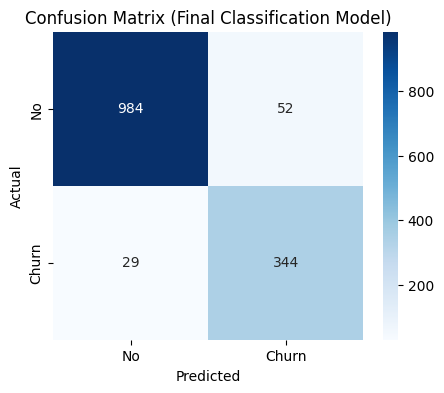

In [13]:
# Check model's performance
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["No", "Churn"],
            yticklabels=["No", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Final Classification Model)")
plt.show()

In [17]:
os.makedirs("models", exist_ok=True)

# Save trained components
joblib.dump(model, '../models/final_churn_lgbm.pkl')
joblib.dump(scaler, '../models/robust_scaler.pkl')
joblib.dump(le_os, '../models/label_encoders.pkl')
joblib.dump(ohe, '../models/onehot_encoder.pkl')


print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!
